**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**September, 2023**

---

# Logistic regression to do trophoblast annotation

Uses the annotation in the Maternal-Fetal Interface reference done by Anna Arutyunyan:


*Arutyunyan, A., Roberts, K., Troulé, K., Wong, F. C., Sheridan, M. A., Kats, I., ... & Vento-Tormo, R. (2023). Spatial multiomics map of trophoblast development in early pregnancy. Nature, 616(7955), 143-151.*

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import anndata
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [6]:
np.random.seed(0)

In [7]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.6
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.3.0
anndata             0.7.6
anyio               NA
attr                21.2.0
babel               2.9.1
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
brotli              NA
cairo               1.20.1
certifi             2021.05.30
cffi                1.14.4
chardet             4.0.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
debugpy             1.3.0
decorator           5.0.9
defusedxml          0.7.1
dunamai             1.5.5
get_version         3.2
google              NA
h5py                3.3.0
idna                2.10
igraph              0.8.3
ipykernel           6.0.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              3.0.1
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.9.0
jupyterlab_server   2.6.0
kiwisolver  

In [8]:
save_path= '../results/log_regression/'

In [9]:
# my train data
#adata_P13 = sc.read('../../cellranger/data/adata_raw_sc_and_sn_with_unified_annotation_upd_20210914.h5ad')
adata_MFIRef = sc.read('../../../scRNAseq/data_integration/data/adata_raw_MFIdata_annotated.h5ad')

In [10]:
# my test data
Trophoblasts = sc.read('../results/scVI/snRNA4_raw_scVIintegrated_Trophoblastonly.h5ad')#'../results/scVI/snRNA5_denoised_scVIintegrated_Trophoblastonly.h5ad')


# Highly variable genes of Trophoblasts



In [11]:
Trophoblasts.X = Trophoblasts.layers["raw_counts"].copy()

In [12]:
Trophoblasts

AnnData object with n_obs × n_vars = 28040 × 36601
    obs: 'sample', 'stage', 'donor', 'hpi', 'infection', 'percent_mito', 'n_counts', 'batch', 'n_genes', 'sample_barcode', 'assignment_SoC', 'donor_deconv', 'donor_souporcell', 'donor_id', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'infection_stage', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scvi', 'cell_typeAll', 'stage_perInfection'
    var: 'gene_ids', 'feature_types', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi', 'donor_id_colors', 'hpi_colors', 'hvg', 'infection_colors', 'is_doublet_colors', 'leiden', 'neighbors', 'sample_colors', 'stage_perInfection_colors', 'umap'
    obsm: 'X_scVI_n_latent_15', 'X_scVI_n_latent_20', 'X_scVI_n_latent_30', 'X_umap', '_scvi_extra_categoricals'
    layers: 'raw_counts'
    obsp: 'connectivities', 'distances'

In [13]:
#neede only when using flavor='seurat'
#sc.pp.normalize_per_cell(Trophoblasts, counts_per_cell_after=1e4)
#sc.pp.log1p(Trophoblasts)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
/opt/conda/envs/scvi-singularity/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


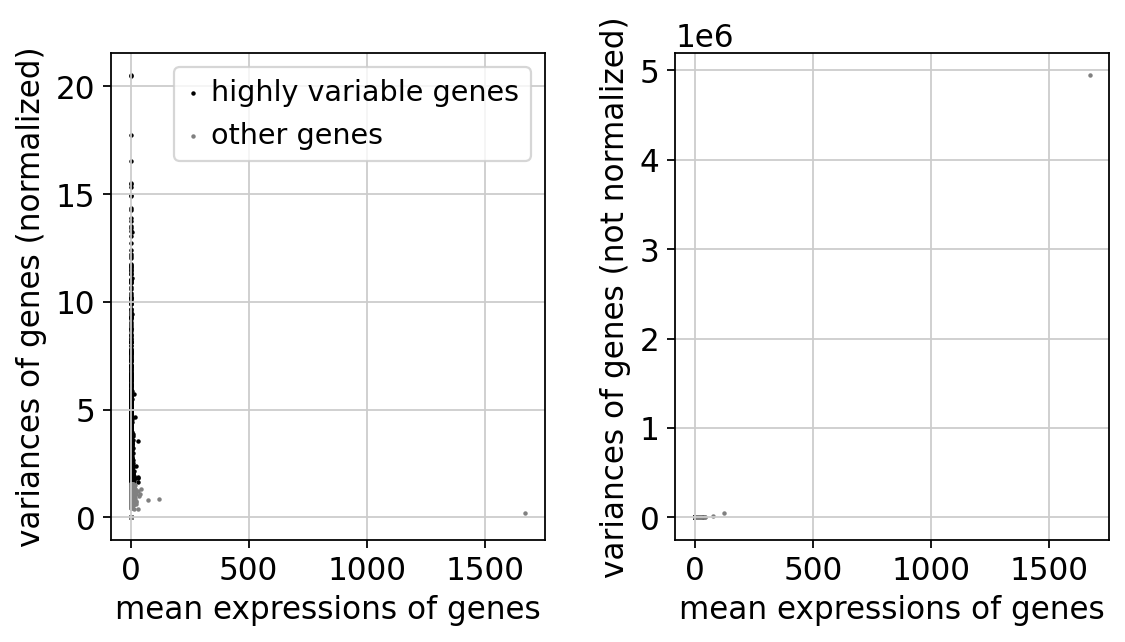

Total number of cells: 28040
Total number of genes: 3000


In [14]:
#  HVGs. Seurat 3 expects non-normalized counts
sc.pp.highly_variable_genes(Trophoblasts, n_top_genes=3000, flavor='seurat_v3')
sc.pl.highly_variable_genes(Trophoblasts)

#saving the highl variable genes
highly_variable_genesTrophoblasts = Trophoblasts.var["highly_variable"]
Trophoblasts = Trophoblasts[:, highly_variable_genesTrophoblasts]

print('Total number of cells: {:d}'.format(Trophoblasts.n_obs))
print('Total number of genes: {:d}'.format(Trophoblasts.n_vars))

In [15]:
Trophoblasts.X = Trophoblasts.layers["raw_counts"].copy()

In [16]:
#Trophoblasts.var.to_csv('../results/exp_infection/tables/highlyVariable_genesTrophoblasts.csv')

# Subsetting the trophoblasts



In [17]:
#set(adata_MFIRef.obs['cell_type'])

In [18]:
MFI_sub = adata_MFIRef[adata_MFIRef.obs['cell_type'].isin(['SCT', 'VCT_CCC', 'VCT_fusing', 'VCT_p', 'VCT', 
                                                           'EVT_1','EVT_2','iEVT','eEVT'])]


In [19]:
MFI_sub

View of AnnData object with n_obs × n_vars = 75023 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'cell_type'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_ids-16', 'feature_types-16', 'genome-16', 'n_cells-16', 'gene_ids-17', 'feature_types-17', 'genome-17', 'n_cells-17', 'gene_ids-18', 'feature_types-18', 'genome-18', 'n_cells-18', 'gene_ids-1

In [20]:
MFI_sub.layers['raw_counts']= MFI_sub.X.copy()

# LOGISTIC REGRESSION

### Subsetting both datasets' copies to common genes only

Can be either overlap of all genes that passed QC or HVG overlap

In [21]:
MFI_sub.var

,gene_ids-0,feature_types-0,genome-0,n_cells-0,gene_ids-1,feature_types-1,genome-1,n_cells-1,gene_ids-10,feature_types-10,...,genome-7,n_cells-7,gene_ids-8,feature_types-8,genome-8,n_cells-8,gene_ids-9,feature_types-9,genome-9,n_cells-9
A1BG,ENSG00000121410,Gene Expression,GRCh38,58.0,ENSG00000121410,Gene Expression,GRCh38,118.0,ENSG00000121410,Gene Expression,...,GRCh38,140.0,ENSG00000121410,Gene Expression,GRCh38,185.0,ENSG00000121410,Gene Expression,GRCh38,608.0
A1BG-AS1,ENSG00000268895,Gene Expression,GRCh38,7.0,ENSG00000268895,Gene Expression,GRCh38,21.0,ENSG00000268895,Gene Expression,...,GRCh38,14.0,ENSG00000268895,Gene Expression,GRCh38,20.0,ENSG00000268895,Gene Expression,GRCh38,91.0
A1CF,nan,nan,nan,NaN,nan,nan,nan,NaN,nan,nan,...,nan,NaN,nan,nan,nan,NaN,nan,nan,nan,NaN
A2M,ENSG00000175899,Gene Expression,GRCh38,66.0,ENSG00000175899,Gene Expression,GRCh38,171.0,ENSG00000175899,Gene Expression,...,nan,NaN,ENSG00000175899,Gene Expression,GRCh38,5.0,ENSG00000175899,Gene Expression,GRCh38,2117.0
A2M-AS1,ENSG00000245105,Gene Expression,GRCh38,6.0,ENSG00000245105,Gene Expression,GRCh38,5.0,ENSG00000245105,Gene Expression,...,GRCh38,59.0,ENSG00000245105,Gene Expression,GRCh38,61.0,ENSG00000245105,Gene Expression,GRCh38,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,ENSG00000070476,Gene Expression,GRCh38,11.0,ENSG00000070476,Gene Expression,GRCh38,21.0,ENSG00000070476,Gene Expression,...,GRCh38,26.0,ENSG00000070476,Gene Expression,GRCh38,32.0,ENSG00000070476,Gene Expression,GRCh38,122.0
ZYG11A,nan,nan,nan,NaN,nan,nan,nan,NaN,nan,nan,...,nan,NaN,nan,nan,nan,NaN,nan,nan,nan,NaN
ZYG11B,ENSG00000162378,Gene Expression,GRCh38,15.0,ENSG00000162378,Gene Expression,GRCh38,41.0,ENSG00000162378,Gene Expression,...,GRCh38,22.0,ENSG00000162378,Gene Expression,GRCh38,47.0,ENSG00000162378,Gene Expression,GRCh38,183.0
ZYX,ENSG00000159840,Gene Expression,GRCh38,134.0,ENSG00000159840,Gene Expression,GRCh38,284.0,ENSG00000159840,Gene Expression,...,GRCh38,265.0,ENSG00000159840,Gene Expression,GRCh38,319.0,ENSG00000159840,Gene Expression,GRCh38,2351.0


In [22]:
##-- needed only when using flavor='seurat'
#sc.pp.normalize_per_cell(MFI_sub, counts_per_cell_after=1e4)
#sc.pp.log1p(MFI_sub)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
/opt/conda/envs/scvi-singularity/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


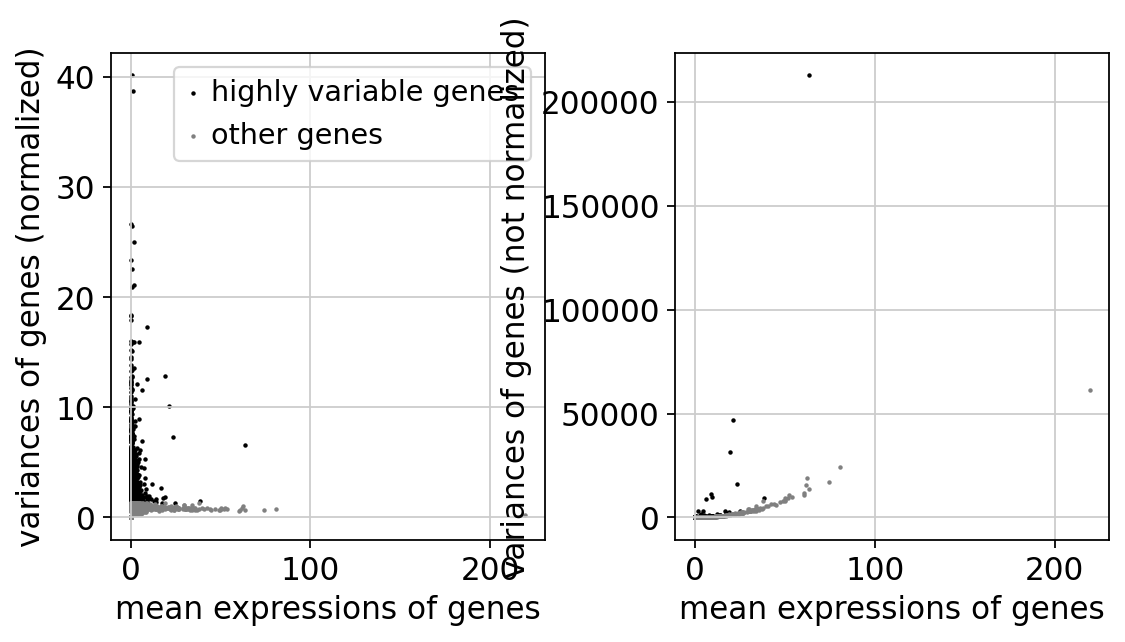

In [23]:
sc.pp.highly_variable_genes(MFI_sub, n_top_genes=3000, flavor='seurat_v3')
sc.pl.highly_variable_genes(MFI_sub)


In [24]:
#saving the highl variable genes
highly_variable_genes = MFI_sub.var["highly_variable"]
MFI_downsampled = MFI_sub[:, highly_variable_genes]

print('Total number of cells: {:d}'.format(MFI_downsampled.n_obs))
print('Total number of genes: {:d}'.format(MFI_downsampled.n_vars))

Total number of cells: 75023
Total number of genes: 3000


In [25]:
MFI_downsampled.X = MFI_downsampled.layers["raw_counts"].copy()

In [26]:

print('Total number of cells: {:d}'.format(Trophoblasts.n_obs))
print('Total number of genes: {:d}'.format(Trophoblasts.n_vars))

Total number of cells: 28040
Total number of genes: 3000


In [27]:
# here using only HVG overlap

# normlog, scaled and HVG subsetted 
adata_train = MFI_downsampled.copy()
sc.pp.normalize_total(adata_train, target_sum=1e4)
sc.pp.scale(adata_train, max_value=10)

# normlog, scaled and HVG subsetted 
adata_test = Trophoblasts.copy()
sc.pp.normalize_total(adata_test, target_sum=1e4)
sc.pp.scale(adata_test, max_value=10)

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [28]:
# list of genes shared between blood and bone marrow data
# doing sorted on the overall list is VERY important for consistent ordering of the genes
common_genes = sorted(list(set(adata_train.var_names) & set(adata_test.var_names)))
print(len(common_genes),"genes are shared between annotated train and our joint data \n",
      len(set(adata_train.var_names)), 'genes in training data \n',
      len((set(adata_test.var_names))), 'genes in test joint data \n')

1159 genes are shared between annotated train and our joint data 
 3000 genes in training data 
 3000 genes in test joint data 



In [29]:
#Subseting the datasets
adata_train_copy = adata_train[:,common_genes]
adata_train_copy.var_names

Index(['A2M', 'AADACL2-AS1', 'AADACL3', 'ABCA1', 'ABCA12', 'ABCB1', 'ABCC11',
       'ABCC9', 'ABHD17C', 'ABHD5',
       ...
       'ZFAND2A', 'ZFP36', 'ZNF114', 'ZNF365', 'ZNF516', 'ZNF521', 'ZNF703',
       'ZNF704', 'ZNF804A', 'ZPLD1'],
      dtype='object', length=1159)

In [30]:
#Subseting the datasets
adata_test_copy = adata_test[:,common_genes]
adata_test_copy.var_names

Index(['A2M', 'AADACL2-AS1', 'AADACL3', 'ABCA1', 'ABCA12', 'ABCB1', 'ABCC11',
       'ABCC9', 'ABHD17C', 'ABHD5',
       ...
       'ZFAND2A', 'ZFP36', 'ZNF114', 'ZNF365', 'ZNF516', 'ZNF521', 'ZNF703',
       'ZNF704', 'ZNF804A', 'ZPLD1'],
      dtype='object', length=1159)

In [31]:
# checking gene correspondence - important!
list(adata_test_copy.var_names) == list(adata_train_copy.var_names)

True

In [32]:
adata_train_copy.obs.head()

,n_genes,sample,technology,tissue,dev_age,donor,dataset,run,number_of_individuals_multiplexed,batch,percent_mito,n_counts,scrublet_score,scrublet_cluster_score,bh_pval,is_doublet,cell_type
barcode_sample,,,,,,,,,,,,,,,,,
AGGGTGAGTAAAGGAG-1_FCA7167219,5291,FCA7167219,10X_3'_scRNA-seq,decidua_immune,13_PCW,6,Vento_Nature,NaN,1,0,0.019406,35504.0,0.186441,0.118367,0.857143,False,VCT
CTGATAGAGCCCAGCT-1_FCA7167219,4070,FCA7167219,10X_3'_scRNA-seq,decidua_immune,13_PCW,6,Vento_Nature,NaN,1,0,0.027002,14851.0,0.186441,0.118367,0.857143,False,EVT_2
GCGCGATAGATATGGT-1_FCA7167219,506,FCA7167219,10X_3'_scRNA-seq,decidua_immune,13_PCW,6,Vento_Nature,NaN,1,0,0.005571,1077.0,0.212500,0.118367,0.857143,False,SCT
ATTACTCTCTGCGGCA-1_FCA7167221,655,FCA7167221,10X_3'_scRNA-seq,decidua_immune,11_PCW,7,Vento_Nature,NaN,1,1,0.003621,1657.0,0.175000,0.167267,0.242677,False,iEVT
CTGATAGAGCCCAGCT-1_FCA7167221,412,FCA7167221,10X_3'_scRNA-seq,decidua_immune,11_PCW,7,Vento_Nature,NaN,1,1,0.044892,646.0,0.090426,0.167267,0.242677,False,EVT_2


In [33]:
np.unique(adata_train_copy.obs['cell_type'],return_counts=True)

(array(['EVT_1', 'EVT_2', 'SCT', 'VCT', 'VCT_CCC', 'VCT_fusing', 'VCT_p',
        'eEVT', 'iEVT'], dtype=object),
 array([ 5289,  2358, 28177, 23472,  3373,  1971,  6679,    28,  3676]))

# Training a logistic regression model on previously annotated 10X data Arutyunyan, et al. 2023

In [34]:
adata_train_copy.obs['cell_type'].head()

barcode_sample
AGGGTGAGTAAAGGAG-1_FCA7167219      VCT
CTGATAGAGCCCAGCT-1_FCA7167219    EVT_2
GCGCGATAGATATGGT-1_FCA7167219      SCT
ATTACTCTCTGCGGCA-1_FCA7167221     iEVT
CTGATAGAGCCCAGCT-1_FCA7167221    EVT_2
Name: cell_type, dtype: category
Categories (9, object): ['EVT_1', 'EVT_2', 'SCT', 'VCT', ..., 'VCT_fusing', 'VCT_p', 'eEVT', 'iEVT']

In [35]:
celltypes_train = adata_train_copy.obs['cell_type']

In [36]:
adata_train_copy.X.shape

(75023, 1159)

### The following cell actually trains the model and may require quite a bit of time if you are using a big training dataset

In [37]:
#12:15
%time
# training a logistic regression model on scRNA-seq data
# takes about 15min for HVGs intersection of trophoblasts (~12k cells)
logisticRegr_sc = LogisticRegression(max_iter = 5000, n_jobs = -1, random_state = 0, C=0.2)
logisticRegr_sc.fit(adata_train_copy.X, celltypes_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


LogisticRegression(C=0.2, max_iter=5000, n_jobs=-1, random_state=0)

In [38]:
# Saving model

#pkl_filename = "./logreg_from_P13_downsampled_no_soupy_genes_coarse_troph_to_all_troph_organoids_premrna_HVGs.pkl"
pkl_filename = "../results/log_regression/logreg_trophoblastOnly_to_explant_HVGs_20230825.pkl"



with open(pkl_filename, 'wb') as file:  
    pickle.dump(logisticRegr_sc, file)

In [39]:
# Load model (scRNA-seq) from file

# which one?
#pkl_filename = "../results/log_regression/logreg_trophoblastOnly_to_explant_premrna_HVGs_20220523.pkl"

#with open(pkl_filename, 'rb') as file:  
#    logisticRegr_sc = pickle.load(file)

In [40]:
logisticRegr_sc

LogisticRegression(C=0.2, max_iter=5000, n_jobs=-1, random_state=0)

In [41]:
%%time
predictions = logisticRegr_sc.predict(adata_test_copy.X)
adata_test_copy.obs['celltype_predictions'] = predictions

Trying to set attribute `.obs` of view, copying.


CPU times: user 1.04 s, sys: 219 ms, total: 1.26 s
Wall time: 1.27 s


In [42]:
%%time
# probabilities
probabilities = logisticRegr_sc.predict_proba(adata_test_copy.X)
probs_adata = []
for i,clus in enumerate(adata_test_copy.obs['celltype_predictions']):
    probs_adata.append(probabilities[i,logisticRegr_sc.classes_==clus][0])



CPU times: user 380 ms, sys: 67.7 ms, total: 448 ms
Wall time: 454 ms


In [44]:
adata_test_copy.obs['celltype_predictions']

Pla_HDBR11923126_AAACCCAGTGGACAGT    VCT_p
Pla_HDBR11923126_AAACCCATCGTCTACC      SCT
Pla_HDBR11923126_AAACGAAGTGGACTGA      SCT
Pla_HDBR11923126_AAACGAATCGCAACAT      VCT
Pla_HDBR11923126_AAACGCTAGAGTCAAT      SCT
                                     ...  
Pla_HDBR13661578_TTTCATGAGTCTAGAA      VCT
Pla_HDBR13661578_TTTCATGCATTAGGCT      SCT
Pla_HDBR13661578_TTTCATGGTATGCTTG      SCT
Pla_HDBR13661578_TTTGGAGAGAGCATAT      VCT
Pla_HDBR13661578_TTTGTTGGTTAAGTCC      VCT
Name: celltype_predictions, Length: 28040, dtype: object

In [45]:
# now you can return to your object transferring celltype predictions and their probabilities from training

# my test object
Trophoblasts.obs['celltype_predictions'] = adata_test_copy.obs.loc[Trophoblasts.obs_names,'celltype_predictions']
Trophoblasts.obs['probabilities'] = probs_adata

Trying to set attribute `.obs` of view, copying.


In [46]:
# you may want to save results at this point
Trophoblasts.obs.loc[:,['celltype_predictions','probabilities']].to_csv('../results/log_regression/logreg_trophoblastOnly_to_explant_HVGs_predictions_20230825.csv')

